# Livetime estimation for 10^-4 uncertainty 

Sanity check!

They key thing is the 1 sigma is 68% confidence, not 95%. 

So, for a two sided distribution the signifcance level, alpha, is 0.32.

## Imports

In [3]:
import numpy as np
from statsmodels.stats.proportion import proportion_confint
from scipy import stats
from scipy.stats import gamma
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use("/exp/mu2e/data/users/sgrant/mu2e.mplstyle")

## Uncertainty estimation methods 

In [4]:
# Theoretical Poisson standard error 
def poisson(k, N):
    return np.sqrt(k) / (N)

z = 1.0 # z-score for 1 sigma (68% confidence)
# z = 1.96 # z-score for 2 sigma (95% confidence)
# z = 2.576 # z-score for 3 sigma (99% confidence)

# confidence = 0.68 # this is 1 sigma 
# alpha = 1 - confidence # two sided, so 16% in each tail

def poisson_confidence_interval(k, N, z=z):
    """
    Poisson confidence interval uncertainty for proportion k/N
    Uses exact Poisson CI for rate lambda, then converts to proportion
    """
    result = []

    # Signifance
    alpha = 2 * (1 - norm.cdf(z)) 
    
    for i_k, i_N in zip(k, N):
            
        # Exact Poisson confidence interval for rate parameter 
        if i_k == 0:
            lower_lambda = 0
            upper_lambda = -np.log(alpha/2) # alpha/2 per tail
        else:
            lower_lambda = stats.chi2.ppf(alpha/2, 2*i_k) / 2
            upper_lambda = stats.chi2.ppf(1 - alpha/2, 2*(i_k+1)) / 2
    
        # Convert to proportion uncertainty
        result.append( (upper_lambda - lower_lambda) / (2 * i_N) )

    return result

# The two poisson CIs are identical
def poisson_gamma_ci(k, N, z=z):
    """
    Poisson confidence interval using gamma distribution
    """
    k = np.asarray(k)
    N = np.asarray(N)
    result = []

    alpha = 2 * (1 - norm.cdf(z))
    
    for i_k, i_N in zip(k, N):
        # Handle potential NaN/invalid values
        if np.isnan(i_k) or np.isnan(i_N) or i_N <= 0:
            result.append(np.nan)
            continue
            
        # Gamma-based Poisson confidence interval
        if i_k == 0:
            lower_lambda = 0
            upper_lambda = gamma.ppf(1 - alpha/2, i_k + 1)
        else:
            lower_lambda = gamma.ppf(alpha/2, i_k)
            upper_lambda = gamma.ppf(1 - alpha/2, i_k + 1)
    
        # Convert to proportion uncertainty
        result.append((upper_lambda - lower_lambda) / (2 * i_N))
    
    return np.array(result)

def wilson(k, N, z=z):
    """
    Wilson confidence interval
    """
    alpha = 2 * (1 - norm.cdf(z))
    lower, upper = proportion_confint(k, N, alpha=alpha, method="wilson")
    return (upper - lower) / 2 

In [5]:
onspill_ds = "MDC2020au"
offspill_ds = "MDC2020as"

## Calculations

In [6]:
# Livetime in days
livetime = (1.06288e+07 / (24*3600)) 
walltime_off = livetime / 0.72
walltime_on = livetime / 0.28

# OFFSPILL
# N_b_off, N_ce_off = 5, 18914
N_b_off, N_ce_off = 7, 19428 # au, updated cut flow with tanDip = pz/pt
# Inefficiency for OFF scenario
ineff_off = N_b_off / N_ce_off
# CE rate for OFF scenario
rate_ce_off = N_ce_off / walltime_off
# Background rate for OFF scenario
rate_b_off = N_b_off / walltime_off

# ONSPILL
# N_b_on, N_ce_on = 6, 11693
N_b_on, N_ce_on = 6, 11961 # au onspill
# Inefficiency for ON scenario
ineff_on = N_b_on / N_ce_on
# CE rate for ON scenario
rate_ce_on = N_ce_on / walltime_on
# Background rate for ON scenario
rate_b_on = N_b_on / walltime_on

# Time in days (0 to 1000 days in 1000 steps)
t = np.linspace(0, 365, 365)

## Plot the number of events

In [7]:
# # Calculate the number of events for each time
# # Force integers
# # N_b_t = np.array(rate_b*t, dtype="int")
# # N_ce_t = np.array(rate_ce*t, dtype="int")

# N_b_t = np.array(rate_b*t).astype(int) # , dtype="int")
# N_ce_t = np.array(rate_ce*t).astype(int) # , dtype="int")

# fig, ax = plt.subplots()
# ax.plot(t, N_ce_t, label="CE-like")
# ax.plot(t, N_b_t, label="Unvetoed CE-like") 
# ax.set_xlabel("Wall time [days]")
# ax.set_ylabel("Events / day")
# ax.set_yscale("log")
# ax.legend()
# plt.show()

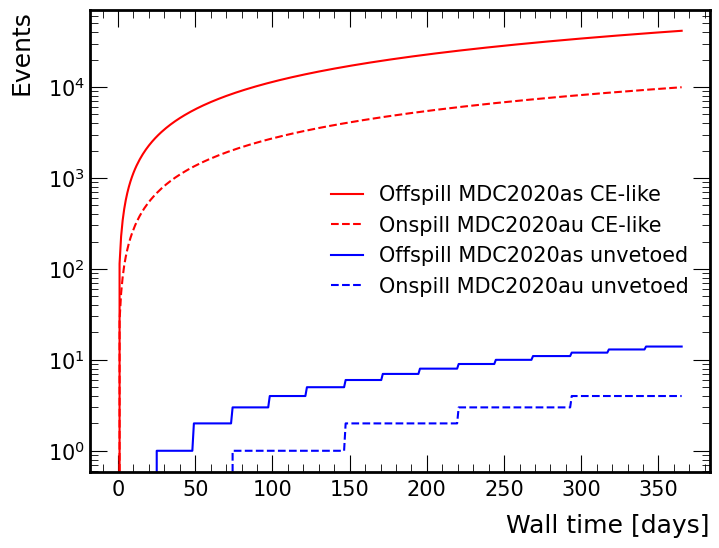

In [8]:
N_b_t_off = np.array(rate_b_off * t).astype(int)
N_ce_t_off = np.array(rate_ce_off * t).astype(int)

N_b_t_on = np.array(rate_b_on * t).astype(int)
N_ce_t_on = np.array(rate_ce_on * t).astype(int)


fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t, N_ce_t_off, label=f"Offspill {offspill_ds} CE-like", color="r")
ax.plot(t, N_ce_t_on, label=f"Onspill {onspill_ds} CE-like", linestyle="--", color="r")
ax.plot(t, N_b_t_off, label=f"Offspill {offspill_ds} unvetoed", color="b")
ax.plot(t, N_b_t_on, label=f"Onspill {onspill_ds} unvetoed", linestyle="--", color="b")
ax.set_xlabel("Wall time [days]")
ax.set_ylabel("Events")
ax.set_yscale("log")
ax.legend()
plt.show()

## Plot the inefficiency 

/tmp/ipykernel_944566/2463963542.py:2: RuntimeWarning: invalid value encountered in divide
  ineff_off = N_b_t_off  / N_ce_t_off
/tmp/ipykernel_944566/2463963542.py:3: RuntimeWarning: invalid value encountered in divide
  ineff_on = N_b_t_on  / N_ce_t_on


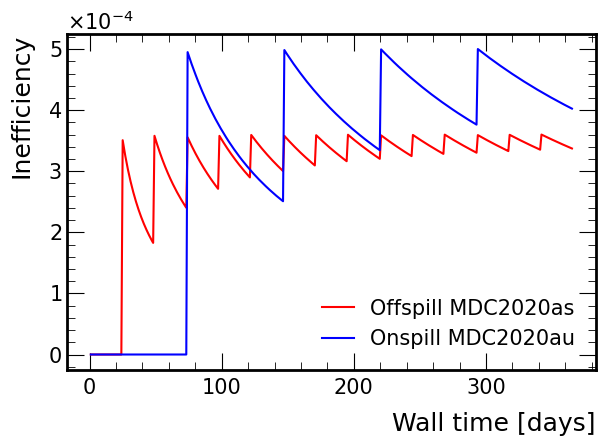

In [9]:
# Calcuate the inefficency
ineff_off = N_b_t_off  / N_ce_t_off
ineff_on = N_b_t_on  / N_ce_t_on

fig, ax = plt.subplots()
ax.plot(t, ineff_off, label=f"Offspill {offspill_ds}") 
ax.plot(t, ineff_on, label=f"Onspill {onspill_ds}") 
ax.set_xlabel("Wall time [days]")
ax.set_ylabel("Inefficiency")
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax.legend()
plt.tight_layout()
plt.show()

## Plot the uncertainties

In [10]:
# Find the target time numerically
def get_target_time(t, unc, target=1e-4):
    for i, value in enumerate(unc):
        if np.isnan(value) or value <= 0:
            continue
        if value <= target:
            return t[i]
            
#             # Linear interpolation between points i-1 and i
#             t1, t2 = t[i-1], t[i]
#             u1, u2 = unc[i-1], unc[i]
            
#             # Interpolate to find exact crossing point
#             # target = u1 + (u2 - u1) * (t_target - t1) / (t2 - t1)
#             # Solve for t_target:
#             t_target = t1 + (target - u1) * (t2 - t1) / (u2 - u1)
#             return t_target
    
#     return None  # Never reaches target

In [11]:
# Uncertainties
# Poisson uncertainties
poisson_unc_off = poisson(N_b_t_off, N_ce_t_off)
poisson_unc_on = poisson(N_b_t_on, N_ce_t_on)

# Poisson confidence intervals
poisson_ci_off = poisson_confidence_interval(N_b_t_off, N_ce_t_off)
poisson_ci_on = poisson_confidence_interval(N_b_t_on, N_ce_t_on)

# Wilson uncertainties
wilson_unc_off = wilson(N_b_t_off, N_ce_t_off)
wilson_unc_on = wilson(N_b_t_on, N_ce_t_on)
# poisson_gamma_ci = poisson_gamma_ci(N_b_t, N_ce_t)

# Poisson uncertainty target times
poisson_target_time_off = get_target_time(t, poisson_unc_off)
poisson_target_time_on = get_target_time(t, poisson_unc_on)

# Poisson confidence interval target times
poisson_ci_target_time_off = get_target_time(t, poisson_ci_off)
poisson_ci_target_time_on = get_target_time(t, poisson_ci_on)

# Wilson uncertainty target times
wilson_target_time_off = get_target_time(t, wilson_unc_off)
wilson_target_time_on = get_target_time(t, wilson_unc_on)

/tmp/ipykernel_944566/2989686586.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(k) / (N)
/tmp/ipykernel_944566/2989686586.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  result.append( (upper_lambda - lower_lambda) / (2 * i_N) )
/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in divide
  q

In [12]:
poisson_ci_target_time_on

TypeError: unsupported format string passed to NoneType.__format__

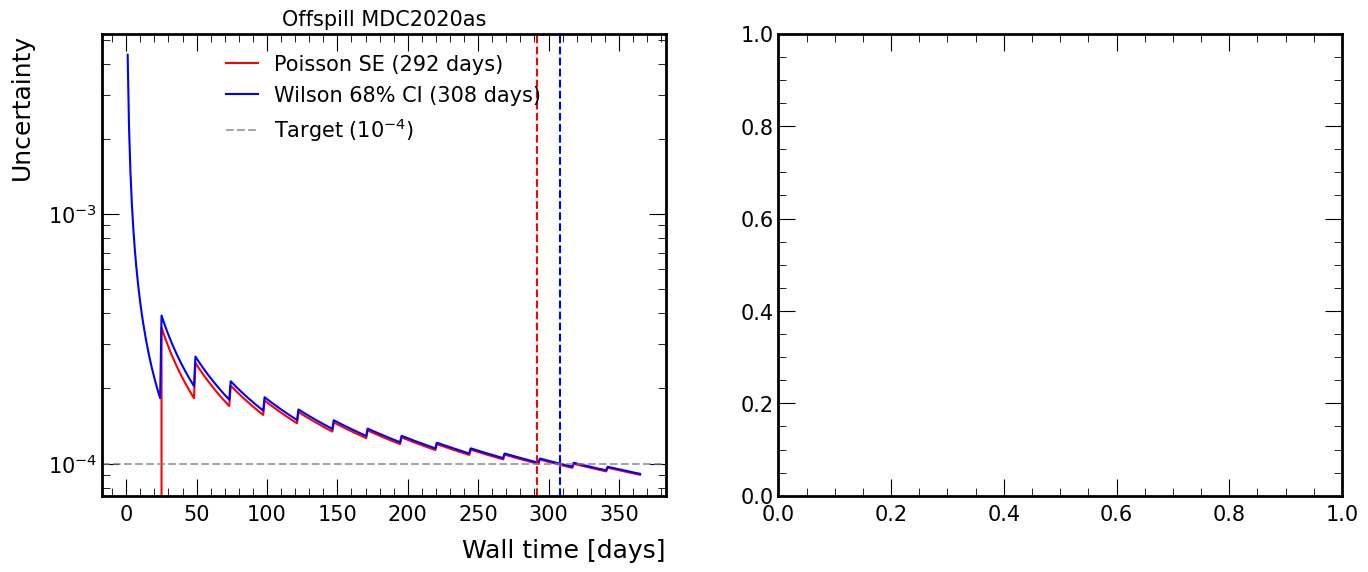

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# OFF scenario (left plot)
ax1.plot(t, poisson_unc_off, label=f"Poisson SE ({poisson_target_time_off:.0f} days)") 
ax1.plot(t, wilson_unc_off, label=rf"Wilson 68% CI ({wilson_target_time_off:.0f} days)") 
# ax1.plot(t, poisson_ci_off, label=rf"Poisson 68% CI ({poisson_ci_target_time_off:.0f} days)") 
ax1.set_xlabel("Wall time [days]")
ax1.set_ylabel("Uncertainty")
ax1.set_title(f"Offspill {offspill_ds}")
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax1.axvline(poisson_target_time_off, linestyle="--", color="red")
ax1.axvline(wilson_target_time_off, linestyle="--", color="blue")
# ax1.axvline(poisson_ci_target_time_off, linestyle="--", color="green")
ax1.axhline(1e-4, color="gray", linestyle="--", alpha=0.7, label=r"Target ($10^{-4}$)")
ax1.legend()
ax1.set_yscale("log")

# ON scenario (right plot)
ax2.plot(t, poisson_unc_on, label=f"Poisson SE ({poisson_target_time_on:.0f} days)") 
ax2.plot(t, wilson_unc_on, label=f"Wilson 68% CI ({wilson_target_time_on:.0f} days)") 
# ax2.plot(t, poisson_ci_on, label=f"Poisson 68% CI ({poisson_ci_target_time_on:.0f} days)") 
ax2.set_xlabel("Wall time [days]")
ax2.set_ylabel("Uncertainty")
ax2.set_title(f"Onspill {onspill_ds}")
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax2.axvline(poisson_target_time_on, linestyle="--", color="red")
ax2.axvline(wilson_target_time_on, linestyle="--", color="blue")
# ax2.axvline(poisson_ci_target_time_on, linestyle="--", color="green")
ax2.axhline(1e-4, color="gray", linestyle="--", alpha=0.7, label=r"Target ($10^{-4}$)")
ax2.legend(loc="upper left") #, frameon=True)
ax2.set_yscale("log")

plt.tight_layout()
# Get today's date in MM-DD-YY format
from datetime import datetime
today = datetime.now().strftime("%m-%d-%y")

plt.savefig(f"../../img/models/plt_on_off_comp_{today}.png", dpi=300)
plt.show()

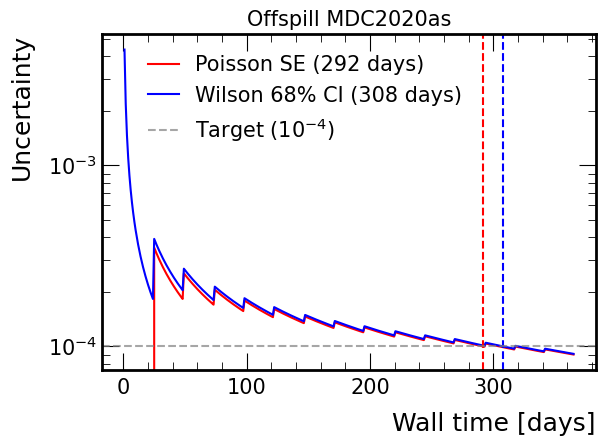

In [22]:
fig, ax1 = plt.subplots() # 1, 2, figsize=(16, 6))

# OFF scenario (left plot)
ax1.plot(t, poisson_unc_off, label=f"Poisson SE ({poisson_target_time_off:.0f} days)") 
ax1.plot(t, wilson_unc_off, label=rf"Wilson 68% CI ({wilson_target_time_off:.0f} days)") 
# ax1.plot(t, poisson_ci_off, label=rf"Poisson 68% CI ({poisson_ci_target_time_off:.0f} days)") 
ax1.set_xlabel("Wall time [days]")
ax1.set_ylabel("Uncertainty")
ax1.set_title(f"Offspill {offspill_ds}")
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax1.axvline(poisson_target_time_off, linestyle="--", color="red")
ax1.axvline(wilson_target_time_off, linestyle="--", color="blue")
# ax1.axvline(poisson_ci_target_time_off, linestyle="--", color="green")
ax1.axhline(1e-4, color="gray", linestyle="--", alpha=0.7, label=r"Target ($10^{-4}$)")
ax1.legend(loc="upper left", bbox_to_anchor=(0.05, 1.0))
ax1.set_yscale("log")

plt.tight_layout()
# Get today's date in MM-DD-YY format
from datetime import datetime
today = datetime.now().strftime("%m-%d-%y")

plt.savefig(f"../../img/models/plt_on_off_comp_{today}.png", dpi=300)
plt.show()

In [11]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 6))
# ax.plot(t, poisson_unc, label=f"Poisson SE ({poisson_target_time:.0f} days)") 
# ax.plot(t, wilson_unc, label=rf"Wilson 68% CI ({wilson_target_time:.0f} days)") 
# ax.plot(t, poisson_ci, label=rf"Poisson 68% CI ({poisson_ci_target_time:.0f} days)") 
# # ax.plot(t, poisson_gamma_ci, label=rf"Poisson/Gamma 68% CI ({poisson_gamma_ci_target_time:.0f} days)") 
# ax.set_xlabel("Wall time [days]")
# ax.set_ylabel("Uncertainty")
# ax.set_title("Offspill")
# ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)

# ax.axvline(poisson_target_time, linestyle="--", color="r")
# ax.axvline(wilson_target_time, linestyle="--", color="b")
# ax.axvline(poisson_ci_target_time, linestyle="--", color="g")
# # ax.axvline(poisson_gamma_ci_target_time, linestyle="--", color="orange")
# ax.axhline(1e-4, color="gray", linestyle="--", alpha=0.7, label=r"Target ($10^{-4}$)")

# ax.legend()#frameon=True)
# ax.set_yscale("log")
# plt.tight_layout()
# plt.savefig("../../img/models/plt_offspill_comp.png", dpi=300)
# plt.show()

So, it looks like Wilson CI is more consistent with the Possion SE, and the Poisson CI is more conservative... 

I think all three are valid, but I like Wilson the best :) 

In [12]:
## Victor's method

/home/sgrant/.conda/envs/ana_v2.0.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/home/sgrant/.conda/envs/ana_v2.0.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/home/sgrant/.conda/envs/ana_v2.0.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/home/sgrant/.conda/envs/ana_v2.0.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)


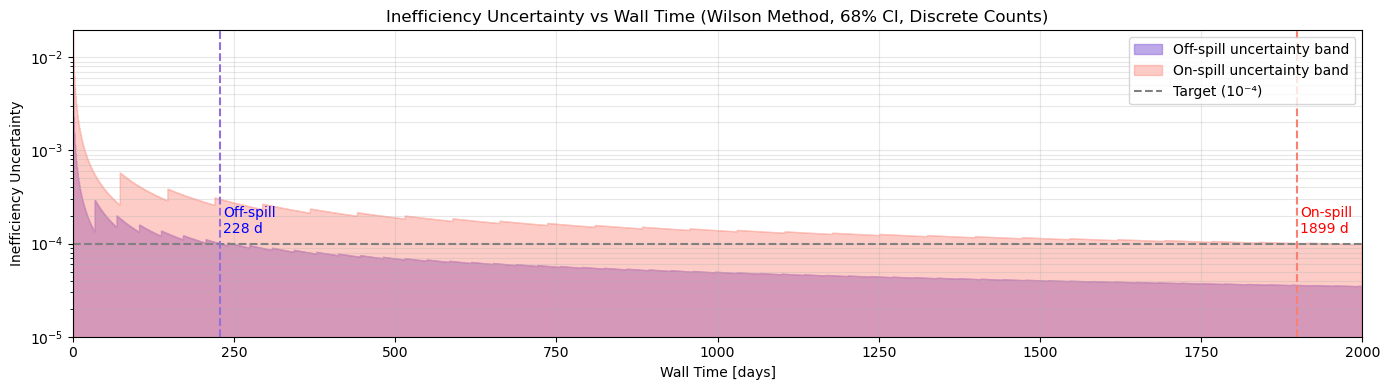

In [13]:

import matplotlib.pyplot as plt
plt.style.use("default") 
import numpy as np
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm

# Wilson uncertainty (half-width) function
def wilson(k, N, z=1.0):  # 68% confidence ⇒ z = 1.0
    alpha = 2 * (1 - norm.cdf(z))
    lower, upper = proportion_confint(k, N, alpha=alpha, method="wilson")
    return (upper - lower) / 2

# Get first time when uncertainty hits target
def get_target_time(t, unc, target=1e-4):
    for i, val in enumerate(unc):
        if np.isnan(val) or val <= 0:
            continue
        if val <= target:
            return t[i]
    return np.nan

# Constants
live_time_sec = 1.06887e7
livetime_days = live_time_sec / (24 * 3600)

N_b_off, N_ce_off = 5, 18914
N_b_on,  N_ce_on  = 6, 11693

# Rates [events per live-day]
rate_b_off = N_b_off / livetime_days
rate_ce_off = N_ce_off / livetime_days
rate_b_on  = N_b_on  / livetime_days
rate_ce_on  = N_ce_on  / livetime_days

# Wall time range [0–2000 days]
t_wall = np.arange(0, 2001, 1)

# Convert wall time → live time
t_live_off = t_wall * 0.72
t_live_on  = t_wall * 0.28

# Discrete, integer counts
N_b_off_t = np.floor(t_live_off * rate_b_off).astype(int)
N_ce_off_t = np.floor(t_live_off * rate_ce_off).astype(int)
N_b_on_t  = np.floor(t_live_on * rate_b_on).astype(int)
N_ce_on_t  = np.floor(t_live_on * rate_ce_on).astype(int)

# Wilson uncertainties (68% CI ⇒ z=1.0)
unc_off = np.array([wilson(k, N, z=1.0) for k, N in zip(N_b_off_t, N_ce_off_t)])
unc_on  = np.array([wilson(k, N, z=1.0) for k, N in zip(N_b_on_t, N_ce_on_t)])

# Target crossing
target = 1e-4
t_off_target = get_target_time(t_wall, unc_off, target)
t_on_target  = get_target_time(t_wall,  unc_on,  target)

# Plot
fig, ax = plt.subplots(figsize=(14, 4))

# Fill uncertainty bands
ax.fill_between(t_wall, 0, unc_off, color='mediumpurple', alpha=0.6, step='mid', label="Off-spill uncertainty band")
ax.fill_between(t_wall, 0, unc_on, color='salmon', alpha=0.4, step='mid', label="On-spill uncertainty band")

# Horizontal target line
ax.axhline(target, color='gray', linestyle='--', label="Target (10⁻⁴)")

# Vertical target lines
if not np.isnan(t_off_target):
    ax.axvline(t_off_target, color='mediumpurple', linestyle='--')
    ax.text(t_off_target + 5, target*1.3, f"Off-spill\n{int(t_off_target)} d", color='blue')

if not np.isnan(t_on_target):
    ax.axvline(t_on_target, color='salmon', linestyle='--')
    ax.text(t_on_target + 5, target*1.3, f"On-spill\n{int(t_on_target)} d", color='red')

# Formatting
ax.set_xlim(0, 2000)
ax.set_ylim(bottom=1e-5)
ax.set_yscale('log')
ax.set_xlabel("Wall Time [days]")
ax.set_ylabel("Inefficiency Uncertainty")
ax.set_title("Inefficiency Uncertainty vs Wall Time (Wilson Method, 68% CI, Discrete Counts)")
ax.legend(loc='upper right')
ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

 

/tmp/ipykernel_944893/2989686586.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(k) / (N)


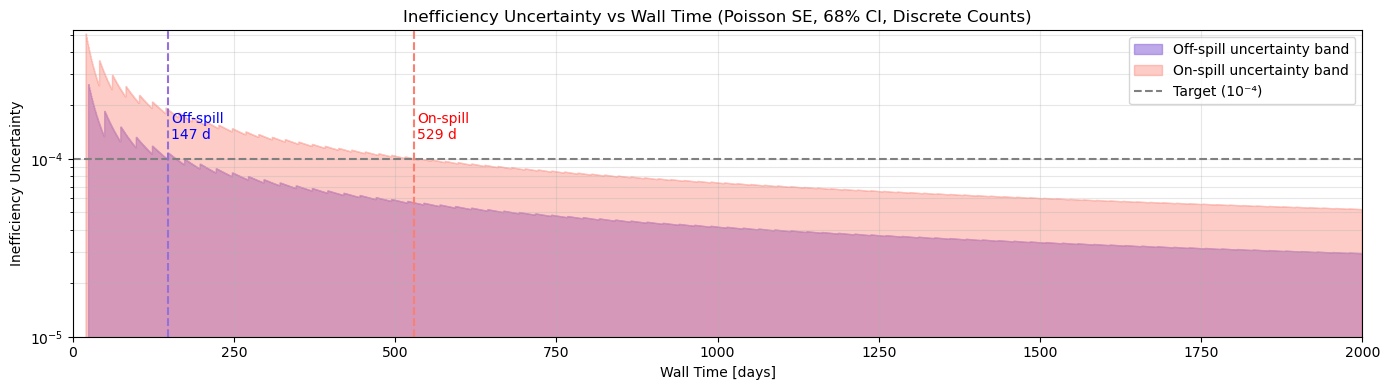

In [14]:

import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm

# Wilson uncertainty (half-width) function
def wilson(k, N, z=1.0):  # 68% confidence ⇒ z = 1.0
    alpha = 2 * (1 - norm.cdf(z))
    lower, upper = proportion_confint(k, N, alpha=alpha, method="wilson")
    return (upper - lower) / 2

# Get first time when uncertainty hits target
def get_target_time(t, unc, target=1e-4):
    for i, val in enumerate(unc):
        if np.isnan(val) or val <= 0:
            continue
        if val <= target:
            return t[i]
    return np.nan

# Constants
live_time_sec = 1.06887e7
livetime_days = live_time_sec / (24 * 3600)

N_b_off, N_ce_off = 5, 18914
N_b_on,  N_ce_on  = 6, 11693

# Rates [events per live-day]
rate_b_off = N_b_off / livetime_days
rate_ce_off = N_ce_off / livetime_days
rate_b_on  = N_b_on  / livetime_days
rate_ce_on  = N_ce_on  / livetime_days

# Wall time range [0–2000 days]
t_wall = np.arange(0, 2001, 1)

# Convert wall time → live time
t_live_off = t_wall #* 0.72
t_live_on  = t_wall #* 0.28

# Discrete, integer counts
N_b_off_t = np.floor(t_live_off * rate_b_off).astype(int)
N_ce_off_t = np.floor(t_live_off * rate_ce_off).astype(int)
N_b_on_t  = np.floor(t_live_on * rate_b_on).astype(int)
N_ce_on_t  = np.floor(t_live_on * rate_ce_on).astype(int)

# Wilson uncertainties (68% CI ⇒ z=1.0)
unc_off = np.array([poisson(k, N) for k, N in zip(N_b_off_t, N_ce_off_t)])
unc_on  = np.array([poisson(k, N) for k, N in zip(N_b_on_t, N_ce_on_t)])

# Target crossing
target = 1e-4
t_off_target = get_target_time(t_wall, unc_off, target)
t_on_target  = get_target_time(t_wall,  unc_on,  target)

# Plot
fig, ax = plt.subplots(figsize=(14, 4))

# Fill uncertainty bands
ax.fill_between(t_wall, 0, unc_off, color='mediumpurple', alpha=0.6, step='mid', label="Off-spill uncertainty band")
ax.fill_between(t_wall, 0, unc_on, color='salmon', alpha=0.4, step='mid', label="On-spill uncertainty band")

# Horizontal target line
ax.axhline(target, color='gray', linestyle='--', label="Target (10⁻⁴)")

# Vertical target lines
if not np.isnan(t_off_target):
    ax.axvline(t_off_target, color='mediumpurple', linestyle='--')
    ax.text(t_off_target + 5, target*1.3, f"Off-spill\n{int(t_off_target)} d", color='blue')

if not np.isnan(t_on_target):
    ax.axvline(t_on_target, color='salmon', linestyle='--')
    ax.text(t_on_target + 5, target*1.3, f"On-spill\n{int(t_on_target)} d", color='red')

# Formatting
ax.set_xlim(0, 2000)
ax.set_ylim(bottom=1e-5)
ax.set_yscale('log')
ax.set_xlabel("Wall Time [days]")
ax.set_ylabel("Inefficiency Uncertainty")
ax.set_title("Inefficiency Uncertainty vs Wall Time (Poisson SE, 68% CI, Discrete Counts)")
ax.legend(loc='upper right')
ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.savefig("/home/sgrant/mu2e_cosmic_ana/mu2e_cosmic_ana/ana/offspill/image.png") #, dpi=300)
plt.show()

 

In [15]:
!pwd

/home/sgrant/mu2e_cosmic_ana/mu2e_cosmic_ana/ana/offspill
